<a href="https://colab.research.google.com/github/Mr-Vicky-06/Week-1-/blob/main/Week_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garbage Classification AI/ML Week 2

This project uses Convolutional Neural Networks (CNNs) in TensorFlow/Keras to classify waste materials into different categories such as plastic, metal, glass, paper, cardboard, and trash. The goal is to assist in automated waste segregation, which can help improve recycling efficiency and reduce environmental impact.

# Garbage Classification with EfficientNetV2B2
**Project Description**

In this project, we aim to develop a sophisticated garbage classification system leveraging the EfficientNetV2B2 architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation.

Goal: To develop an accurate and efficient garbage classification model using EfficientNetV2B2 and transfer learning for automated waste sorting.

Core Libraries

tensorflow: For deep learning model building and training.

numpy: For numerical operations and array manipulation.

matplotlib.pyplot: For plotting training curves and results.

In [19]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

**To Upload a folder to a google colab**



In [10]:
from google.colab import files
uploaded = files.upload()

Saving Garbagedataset.zip to Garbagedataset.zip


In [13]:
# prompt: unzip the folder Garbgedataset.zip

!unzip /content/Garbagedataset.zip

Archive:  /content/Garbagedataset.zip
   creating: Garbagedataset/
   creating: Garbagedataset/cardboard/
  inflating: Garbagedataset/cardboard/cardboard1.jpg  
  inflating: Garbagedataset/cardboard/cardboard10.jpg  
  inflating: Garbagedataset/cardboard/cardboard100.jpg  
  inflating: Garbagedataset/cardboard/cardboard101.jpg  
  inflating: Garbagedataset/cardboard/cardboard102.jpg  
  inflating: Garbagedataset/cardboard/cardboard103.jpg  
  inflating: Garbagedataset/cardboard/cardboard104.jpg  
  inflating: Garbagedataset/cardboard/cardboard105.jpg  
  inflating: Garbagedataset/cardboard/cardboard106.jpg  
  inflating: Garbagedataset/cardboard/cardboard107.jpg  
  inflating: Garbagedataset/cardboard/cardboard108.jpg  
  inflating: Garbagedataset/cardboard/cardboard109.jpg  
  inflating: Garbagedataset/cardboard/cardboard11.jpg  
  inflating: Garbagedataset/cardboard/cardboard110.jpg  
  inflating: Garbagedataset/cardboard/cardboard111.jpg  
  inflating: Garbagedataset/cardboard/cardb

Load image dataset using tools like image_dataset_from_directory.

Split data into training, validation, and testing sets.

tf.keras.utils.image_dataset_from_directory(...)
Used to load images from a directory where each subfolder represents a class.

In [20]:
dataset_dir= r"/content/Garbagedataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [23]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

**TO see the class Which are used for the Classificartion of Garbage**

In [24]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


**Visualize sample images from each class**

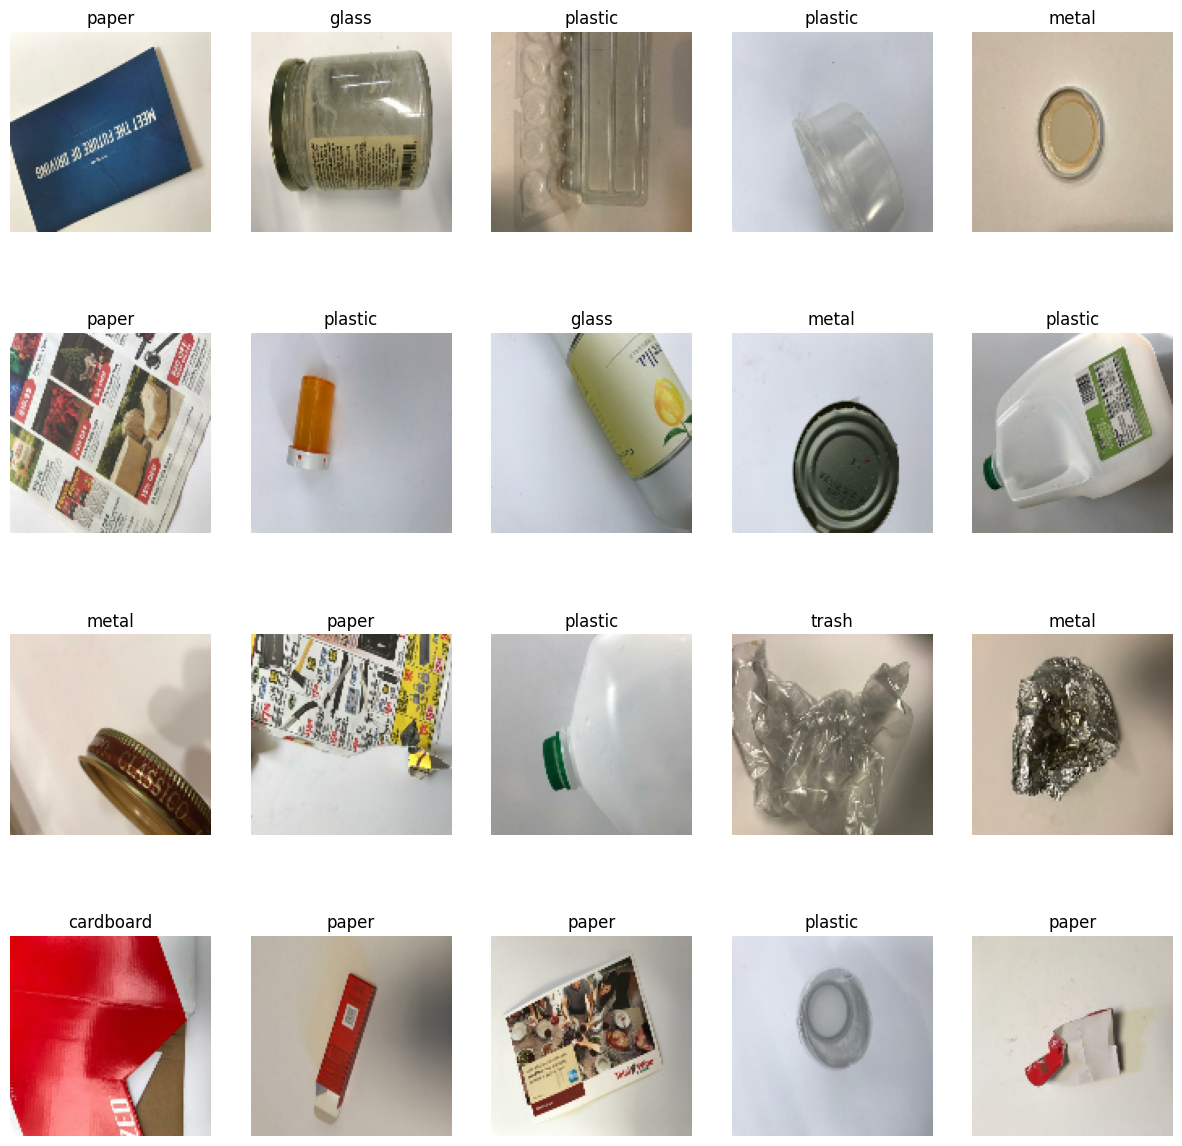

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

*   Check the number of images per class to ensure balance
*  Understand image properties like Image dimensions, Class labels bold text

In [28]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts

In [29]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [30]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}


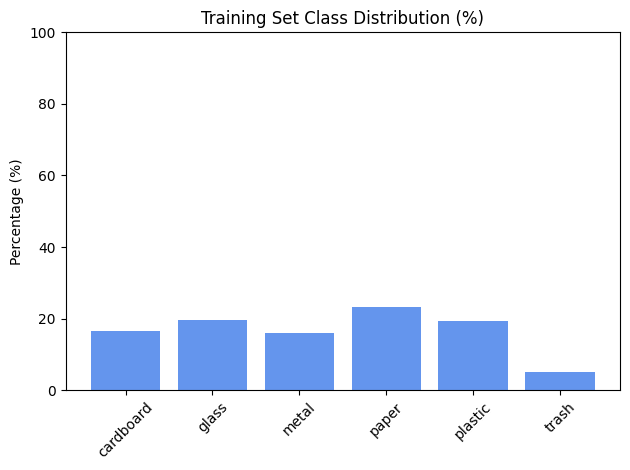

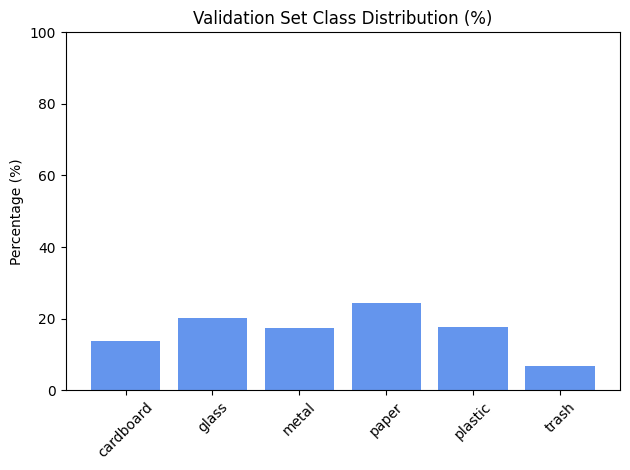

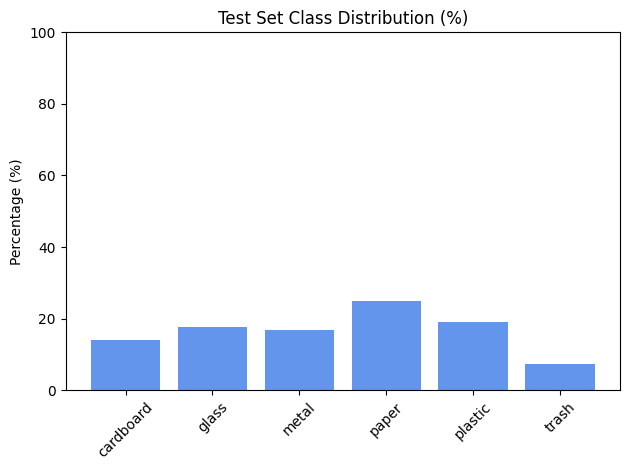

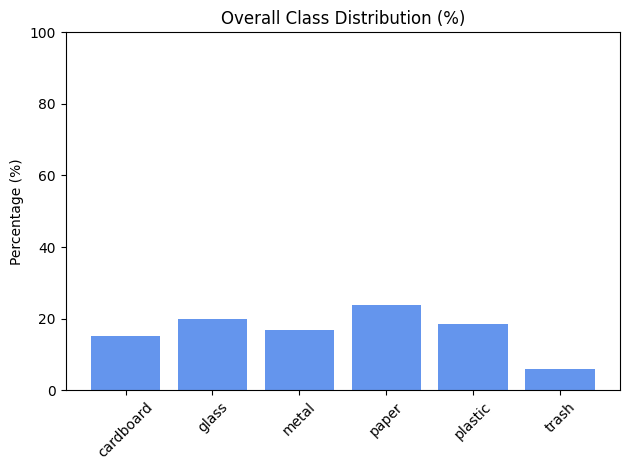

In [31]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

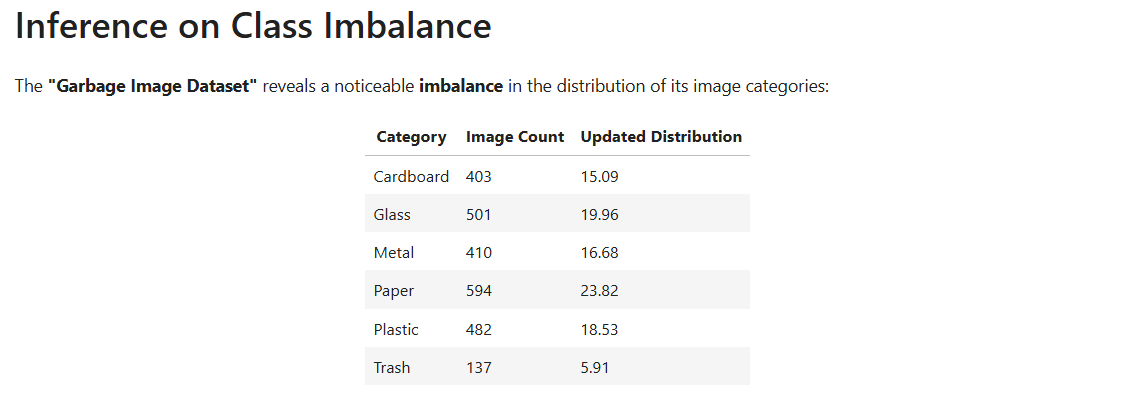

In [32]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [33]:
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


# Data Preprocessing / Preparation

*   Resize and rescale images.
*   Apply data augmentation (e.g., RandomFlip, RandomRotation, RandomZoom) to improve generalization.
*   Normalize images (using preprocess_input if using pre-trained models like EfficientNet).




In [35]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Model Selection
*  Choose a base model: Custom CNN or Transfer Learning (e.g., * * EfficientNetV2B2).
*  Decide whether to use pre-trained weights (e.g., ImageNet).
*  Define whether layers should be trainable or frozen during initial training.

In [36]:
#  Load the pretrained MobileNetV3Small model (without the top classification layer)
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Model Training
* Build the model architecture using Sequential or Functional API.
* Compile the model with loss function ( sparse_categorical_crossentropy), optimizer (e.g., Adam), and evaluation metrics (accuracy).

# Model Tuning and Optimization
* Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
* Use callbacks: EarlyStopping,
* Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

# Model Architecture and Layer Utilities
* **Sequential:** A simple way to build models by stacking layers one after the other in a linear fashion.

* **RandomFlip:** A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

* **RandomRotation:** Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

* **RandomZoom:**Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

* **Dropout:** A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

* **GlobalAveragePooling2D:** Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

* **Dense:**A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

* **Input:** Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

* **EfficientNetV2B2:**A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.

In [37]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])

In [38]:
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 🔁 Callbacks
* **EarlyStopping:** To stop training when validation performance stops improving

In [40]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

# Train the model using .fit() with appropriate epochs, batch_size, and callbacks like EarlyStopping.

In [41]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_ds,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.2794 - loss: 1.7170 - val_accuracy: 0.5861 - val_loss: 1.2149
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.6591 - loss: 1.0672 - val_accuracy: 0.7426 - val_loss: 0.8540
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.7495 - loss: 0.7391 - val_accuracy: 0.8040 - val_loss: 0.6374
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.8443 - loss: 0.5033 - val_accuracy: 0.8455 - val_loss: 0.5392
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 172s 3s/step - accuracy: 0.8880 - loss: 0.3587 - val_accuracy: 0.8614 - val_loss: 0.4629
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.9110 - loss: 0.2834 - val_accuracy: 0.8772 - val_loss: 0.4087
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.9196 - loss: 0.2345 - val_accuracy: 0.8871 - val_loss: 0.3595
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9369 - loss: 0.2131 - val_accuracy: 0.8851 - v

In [42]:
# 📝 Summary (optional but useful)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 124, 124, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [43]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 124, 124,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 124, 124,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 62, 62,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 62, 62,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 62, 62,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 62, 62,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 62, 62,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 62, 62,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 62, 62,    │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 62, 62,    │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 62, 62,    │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 62, 62,    │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 31, 31,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 31, 31,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 31, 31,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

# Model Performance Visualization: Accuracy & Loss Trends

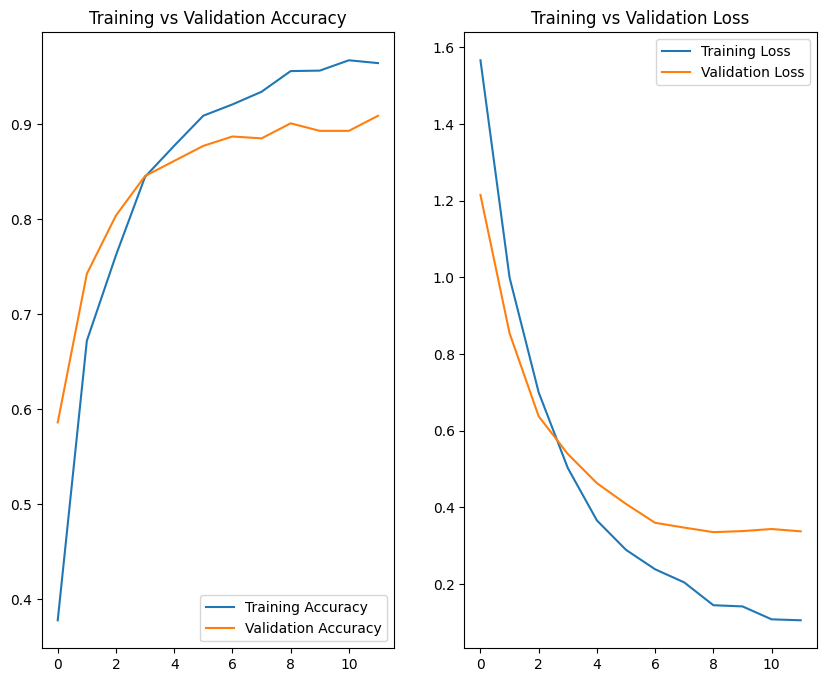

In [44]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots

# Model Evaluation
* Plot training and validation accuracy/loss curves.
* Evaluate model performance on validation or test set.
* Use metrics like:
    * Confusion Matrix
    * Classification Report (Precision, Recall, F1-score)
    * confusion_matrix, classification_report: To evaluate the model's classification performance.

In [45]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 754ms/step - accuracy: 0.9021 - loss: 0.3327
Test accuracy is0.9023, Test loss is 0.3517


In [46]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
[[32  0  0  2  0  1]
 [ 0 48  5  0  2  0]
 [ 0  0 35  0  1  0]
 [ 2  0  0 66  0  2]
 [ 0  2  2  1 39  2]
 [ 2  0  1  0  0 11]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        35
           1       0.96      0.87      0.91        55
           2       0.81      0.97      0.89        36
           3       0.96      0.94      0.95        70
           4       0.93      0.85      0.89        46
           5       0.69      0.79      0.73        14

    accuracy                           0.90       256
   macro avg       0.87      0.89      0.88       256
weighted avg       0.91      0.90      0.90       256



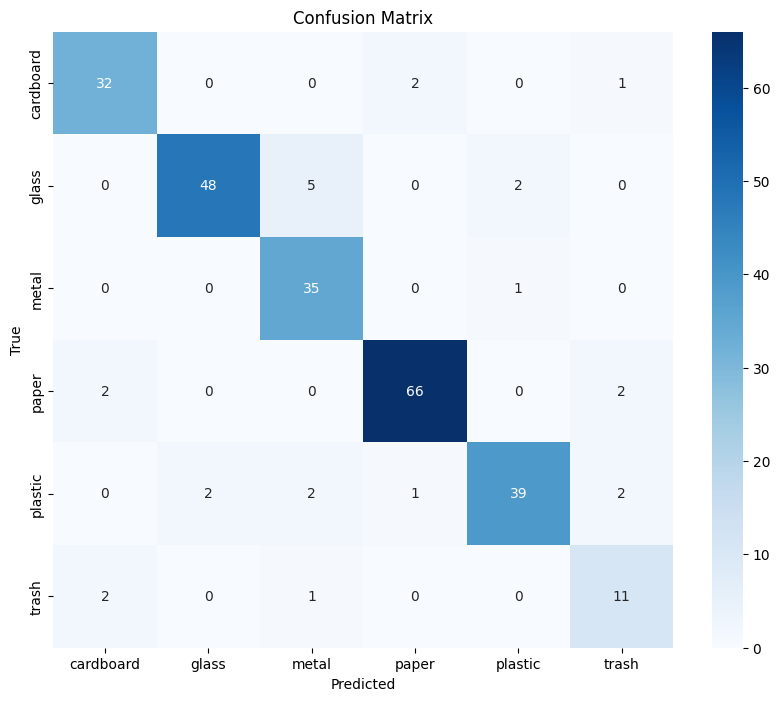

In [47]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

# **Final Testing and Save the Model**
* Evaluate the final model on the unseen test dataset.




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


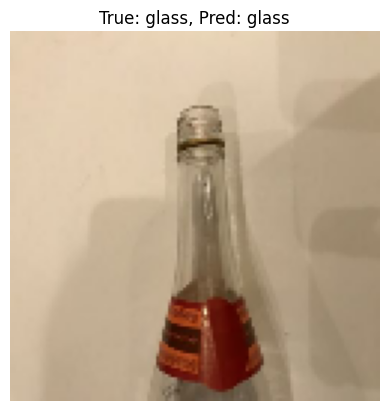

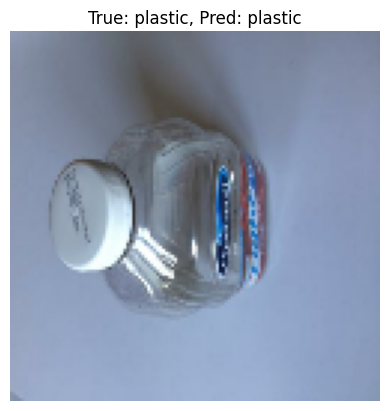

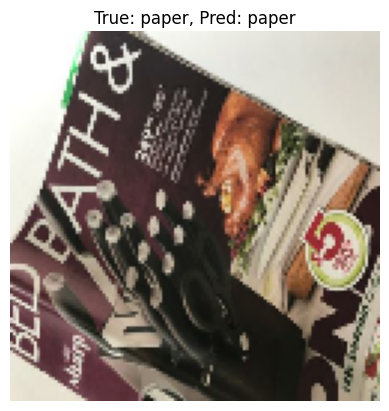

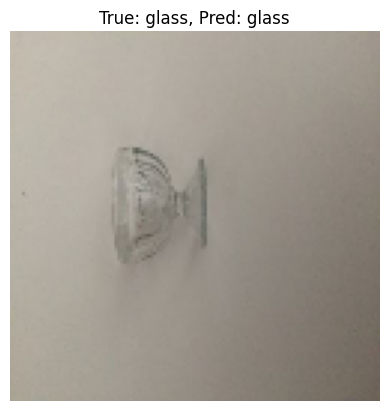

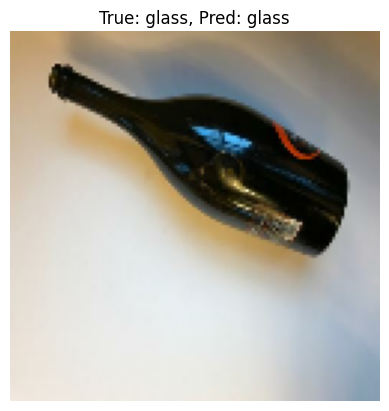

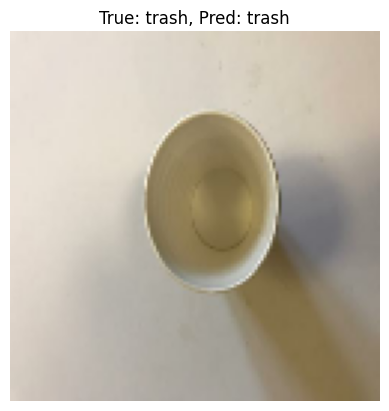

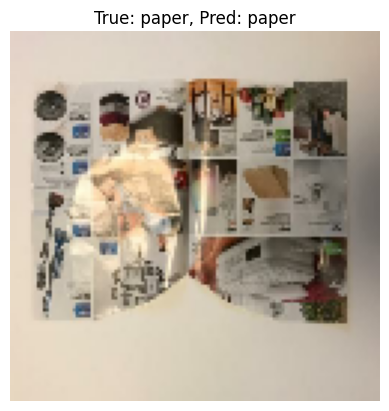

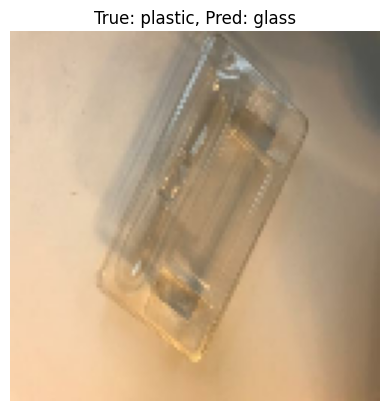

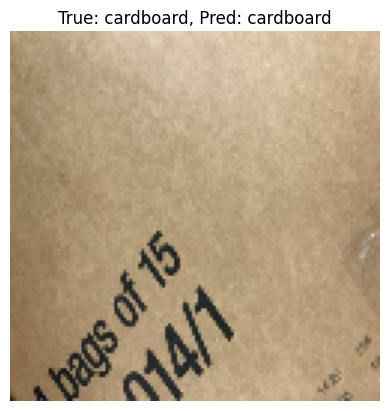

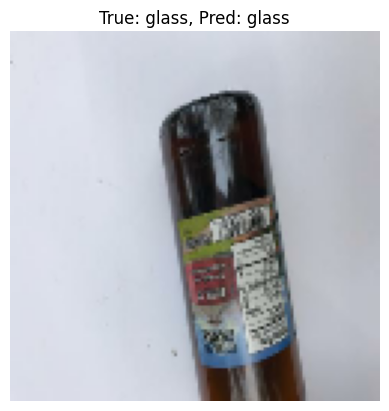

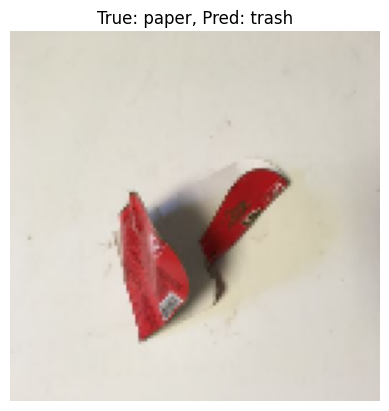

In [49]:
# Extract class names from the training dataset
class_names = train_ds.class_names

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):

    # Generate predictions for the batch of images
    predictions = model.predict(images)

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)

    # Loop through the first 8 images in the batch
    for i in range(11):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title